In [24]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm

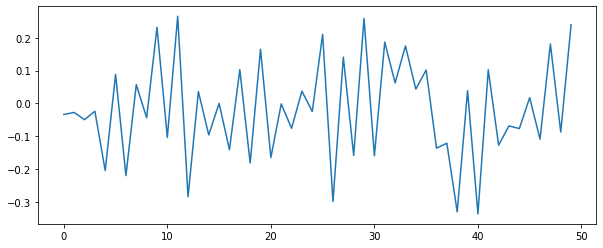

In [12]:
true_phi_1 = -0.2
true_phi_2 = 0.5
true_sigma = 0.1

xvals = [np.random.normal(0, true_sigma), np.random.normal(0, true_sigma)]
for _ in range(50):
    xvals.append(true_phi_1*xvals[-1] + true_phi_2*xvals[-2] + np.random.normal(0, true_sigma))
xvals = np.array(xvals[2:])
plt.figure(figsize=(10,4))
plt.plot(xvals)

In [29]:
model = sm.tsa.arima.model.ARIMA(xvals, order = (2,0,0))

In [32]:
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                 ARIMA(2, 0, 0)   Log Likelihood                  38.784
Date:                Mon, 13 Jun 2022   AIC                            -69.569
Time:                        16:56:39   BIC                            -61.921
Sample:                             0   HQIC                           -66.656
                                 - 50                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0181      0.024     -0.752      0.452      -0.065       0.029
ar.L1         -0.2260      0.126     -1.787      0.074      -0.474       0.022
ar.L2          0.5563      0.126      4.403      0.000       0.309       0.804
sigma2         0.0122      0.003      4.369      0.000       0.007       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.77   Prob(JB):                         0.62
Heteroskedasticity (H):               1.38   Skew:                            -0.31
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

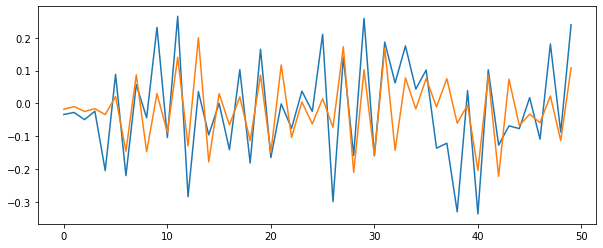

In [34]:
plt.figure(figsize=(10,4))
plt.plot(xvals)
plt.plot(res.fittedvalues)

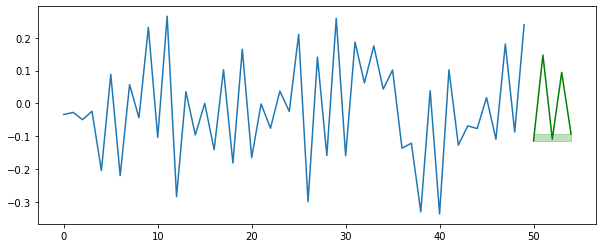

In [58]:
plt.figure(figsize=(10,4))
plt.plot(xvals)
forecast = res.forecast(5)
plt.plot(range(len(xvals), len(xvals) + 5), forecast[0:], color = 'g')
plt.fill_between(range(len(xvals), len(xvals) + 5), forecast[0], forecast[4], color='g', alpha=0.25)

# Bayesian Analysis with PYMC3

$\phi_1 \sim N(0,20)$   

$\phi_2 \sim N(0,20)$   

$\sigma \sim Exp(1)$

C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  va

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 70 seconds.
C:\Users\zaneh\AppData\Local\Temp\ipykernel_21348\3086570598.py:13: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\zaneh\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


<Figure size 504x504 with 0 Axes>

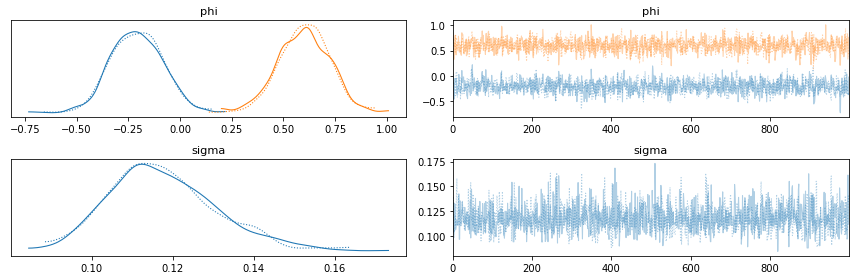

In [59]:
with pm.Model() as bayes_model:
    #priors
    phi = pm.Normal("phi", mu=0, sigma=20, shape=2)
    sigma = pm.Exponential("sigma", lam=1)

    #Likelihood
    likelihood = pm.AR("x", phi, sigma, observed=xvals)

    #posterior
    trace = pm.sample(1000, cores=2)
    
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()



In [65]:
phi1_vals = trace.get_values('phi')[:,0]
phi2_vals = trace.get_values('phi')[:,1]
sigma_vals = trace.get_values('sigma')

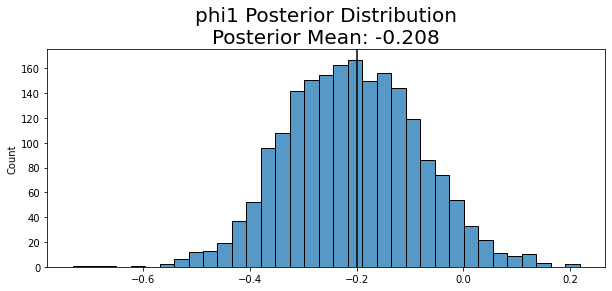

In [71]:
plt.figure(figsize=(10,4))
sns.histplot(phi1_vals)
plt.axvline(true_phi_1, color='k')
plt.title('phi1 Posterior Distribution\nPosterior Mean: %s'%round(phi1_vals.mean(), 3), fontsize=20)
plt.show()

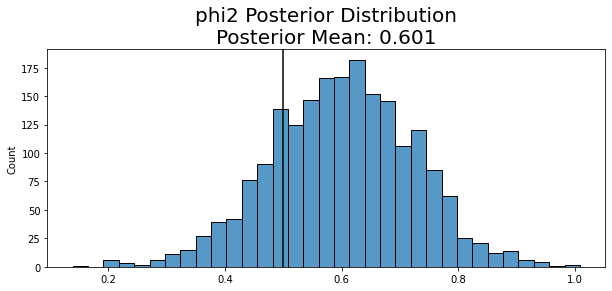

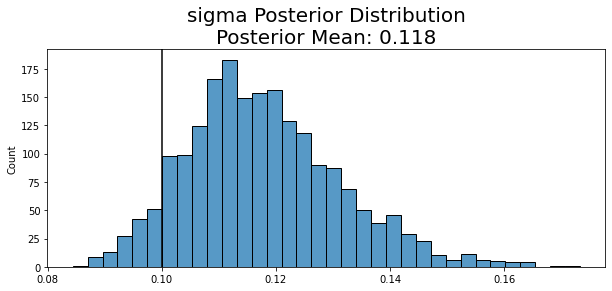

In [73]:
plt.figure(figsize=(10,4))
sns.histplot(phi2_vals)
plt.axvline(true_phi_2, color='k')
plt.title('phi2 Posterior Distribution\nPosterior Mean: %s'%round(phi2_vals.mean(), 3), fontsize=20)
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(sigma_vals)
plt.axvline(true_sigma, color='k')
plt.title('sigma Posterior Distribution\nPosterior Mean: %s'%round(sigma_vals.mean(), 3), fontsize=20)
plt.show()

# Forecast the next values

In [86]:
num_samples = 10000
forecasted_vals = []
num_periods = 5

for x in range(num_samples):
    curr_vals = list(xvals.copy())
    
    phi1_val = np.random.choice(phi1_vals)
    phi2_val = np.random.choice(phi2_vals)
    sigma_val = np.random.choice(sigma_vals)
    
    for z in range(num_periods):
        curr_vals.append(curr_vals[-1]*phi1_val + curr_vals[-2]*phi2_val + np.random.normal(0, sigma_val))
    forecasted_vals.append(curr_vals[-num_periods:]) 
forecasted_vals = np.array(forecasted_vals)

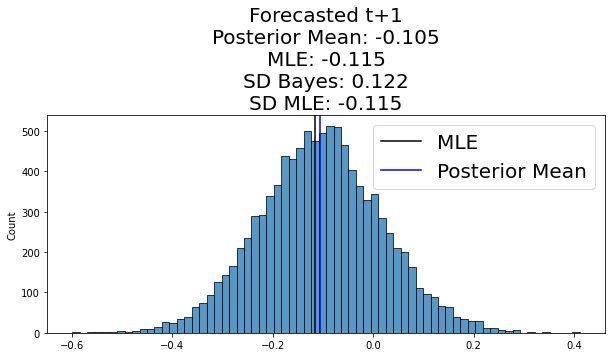

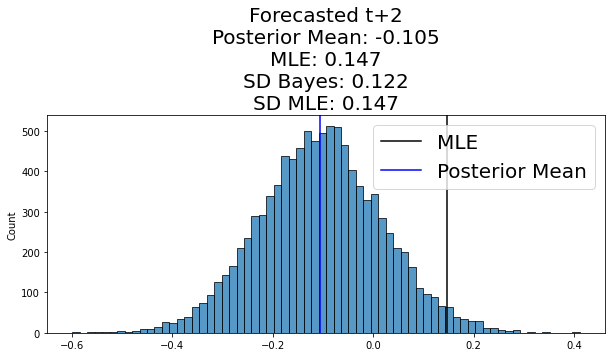

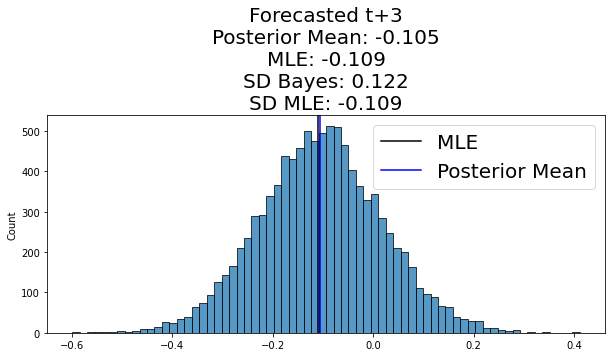

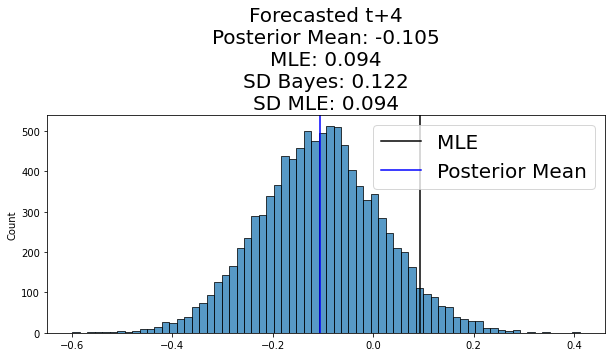

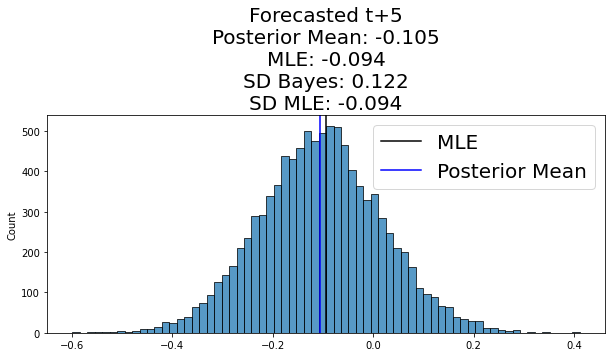

In [102]:
for i in range(num_periods):
    plt.figure(figsize = (10,4))
    vals = forecasted_vals[:,0]
    mu, dev = round(vals.mean(), 3), round(vals.std(), 3)
    sns.histplot(vals)
    p1 = plt.axvline(forecast[i], color='k')
    p2 = plt.axvline(vals.mean(), color='b')
    plt.legend((p1,p2), ('MLE', 'Posterior Mean'), fontsize=20)
    plt.title('Forecasted t+%s\nPosterior Mean: %s\nMLE: %s\nSD Bayes: %s\nSD MLE: %s'%((i+1), 
                                                                                        mu, 
                                                                                        round(forecast[i],3), 
                                                                                        dev, 
                                                                                        round(forecast[i],3)), 
              fontsize=20)




